In [90]:
import sys
from collections import Counter
from music21 import converter, note, key, stream, meter
import matplotlib.pyplot as plt
from collections import defaultdict

In [91]:
def plot_notes_by_beat(beat_note_counts):
    import matplotlib.pyplot as plt

    # Organize data
    beats = sorted(beat_note_counts.keys())
    all_pitches = sorted({p for counter in beat_note_counts.values() for p in counter})

    plt.figure(figsize=(12, 6))

    # Plot each pitch as scatter points
    for pitch in all_pitches:
        x = []
        y = []
        sizes = []
        for beat in beats:
            count = beat_note_counts[beat].get(pitch, 0)
            if count > 0:
                x.append(beat)
                y.append(pitch)
                sizes.append(count * 20)  # Adjust marker size scaling as needed

        plt.scatter(x, y, s=sizes, alpha=0.6, label=pitch)

    plt.title("Note Occurrences by Beat Position")
    plt.xlabel("Beat Number in Measure")
    plt.ylabel("Pitch")
    plt.legend(loc="upper right", fontsize="small", ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    


def plot_note_frequencies(note_list, detected_key):
    note_counts = Counter(note_list)
    labels, counts = zip(*sorted(note_counts.items(), key=lambda x: x[0]))

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, counts, color='skyblue', edgecolor='black')

    # Highlight notes in the key
    in_key = set(p.name for p in detected_key.pitches)
    for bar, label in zip(bars, labels):
        if label not in in_key:
            bar.set_color('salmon')

    plt.title(f"Note Occurrences in MIDI (Key: {detected_key})")
    plt.xlabel("Note Name (no octave)")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()



In [92]:
def plot_velocity_occurrences_by_beat(velocity_counts_per_beat):
    import matplotlib.pyplot as plt

    beats = sorted(velocity_counts_per_beat.keys())
    all_velocities = sorted({v for counter in velocity_counts_per_beat.values() for v in counter})

    plt.figure(figsize=(12, 6))

    # Create scatter points for each velocity value
    for velocity in all_velocities:
        x = []
        y = []
        sizes = []
        for beat in beats:
            count = velocity_counts_per_beat[beat].get(velocity, 0)
            if count > 0:
                x.append(beat)
                y.append(velocity)
                sizes.append(count * 20)  # Scale marker size for visibility

        plt.scatter(x, y, s=sizes, alpha=0.6, label=f"Vel {velocity}")

    plt.title("Velocity Occurrence Count by Beat")
    plt.xlabel("Beat Number in Measure")
    plt.ylabel("Velocity")
    plt.legend(loc="upper right", fontsize="small", ncol=3)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_velocity_by_beat(velocity_per_beat):
    import matplotlib.pyplot as plt

    beats = sorted(velocity_per_beat.keys())
    avg_velocities = [sum(velocity_per_beat[b]) / len(velocity_per_beat[b]) for b in beats]

    plt.figure(figsize=(10, 5))
    plt.plot(beats, avg_velocities, marker='o', color='purple')
    plt.title("Average Note Velocity by Beat")
    plt.xlabel("Beat Number in Measure")
    plt.ylabel("Average Velocity")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [93]:
def analyze_midi_key_compliance(file_path):
    # Parse the MIDI file
    try:
        midi_stream = converter.parse(file_path)
    except Exception as e:
        print(f"❌ Failed to parse MIDI: {e}")
        return

    # Detect key
    try:
        detected_key = midi_stream.analyze('key')
    except Exception as e:
        print(f"❌ Failed to detect key: {e}")
        return

    allowed_notes = set(p.name for p in detected_key.pitches)

    print(f"\n🎼 Detected Key: {detected_key}")
    print(f"🎵 Allowed Notes: {sorted(allowed_notes)}\n")

    note_names = []
    non_conforming = []

    # Collect note data
    for element in midi_stream.recurse():
        if isinstance(element, note.Note):
            name = element.pitch.name  # e.g. "C#", "A"
            note_names.append(name)
            if name not in allowed_notes:
                non_conforming.append((name, element.offset))

    total_notes = len(note_names)

    # Display compliance results
    if non_conforming:
        print(f"❌ Found {len(non_conforming)} non-conforming notes (out of {total_notes}):")
        for pitch, offset in non_conforming:
            print(f" - {pitch} at offset {offset}")
    else:
        print("✅ All notes conform to the detected key.")

    # Plot note frequency
    plot_note_frequencies(note_names, detected_key)

    note_names = []
    non_conforming = []
    beat_note_counts = defaultdict(Counter)
    time_signatures = []
    velocity_per_beat = defaultdict(list)
    velocity_counts_per_beat = defaultdict(Counter)



    for element in midi_stream.recurse():
        if isinstance(element, meter.TimeSignature):
            time_signatures.append((element.ratioString, element.offset))

        if isinstance(element, note.Note):
            name = element.pitch.name
            beat = round(element.beat, 2)  # round for grouping
            note_names.append(name)

            if name not in allowed_notes:
                non_conforming.append((name, element.offset))

            beat_note_counts[beat][name] += 1
            velocity_per_beat[beat].append(element.volume.velocity or 64)  # MIDI default = 64
            velocity_counts_per_beat[beat][element.volume.velocity] += 1

    # Print time signature info
    print("\n🕐 Time Signature(s) detected:")
    for ts, offset in time_signatures:
        print(f" - {ts} at offset {offset}")

    # ... [existing compliance and plotting code]

    print("\n📊 Note occurrences per beat position (aggregated):")
    for beat in sorted(beat_note_counts):
        print(f" Beat {beat}:")
        for pitch, count in beat_note_counts[beat].items():
            print(f"   - {pitch}: {count}")

    plot_notes_by_beat(beat_note_counts)

    plot_velocity_by_beat(velocity_per_beat)
    plot_velocity_occurrences_by_beat(velocity_counts_per_beat)


🎼 Detected Key: g minor
🎵 Allowed Notes: ['A', 'B-', 'C', 'D', 'E-', 'F', 'G']

❌ Found 20 non-conforming notes (out of 53):
 - B at offset 1.0
 - B at offset 5/3
 - C# at offset 7/3
 - G# at offset 0.0
 - E at offset 4/3
 - G# at offset 2.75
 - C# at offset 3.0
 - B at offset 1.0
 - F# at offset 1.5
 - F# at offset 2.25
 - F# at offset 11/3
 - F# at offset 0.0
 - G# at offset 1.0
 - C# at offset 7/3
 - G# at offset 0.25
 - F# at offset 7/3
 - E at offset 11/3
 - E at offset 0.0
 - G# at offset 0.5
 - G# at offset 4/3


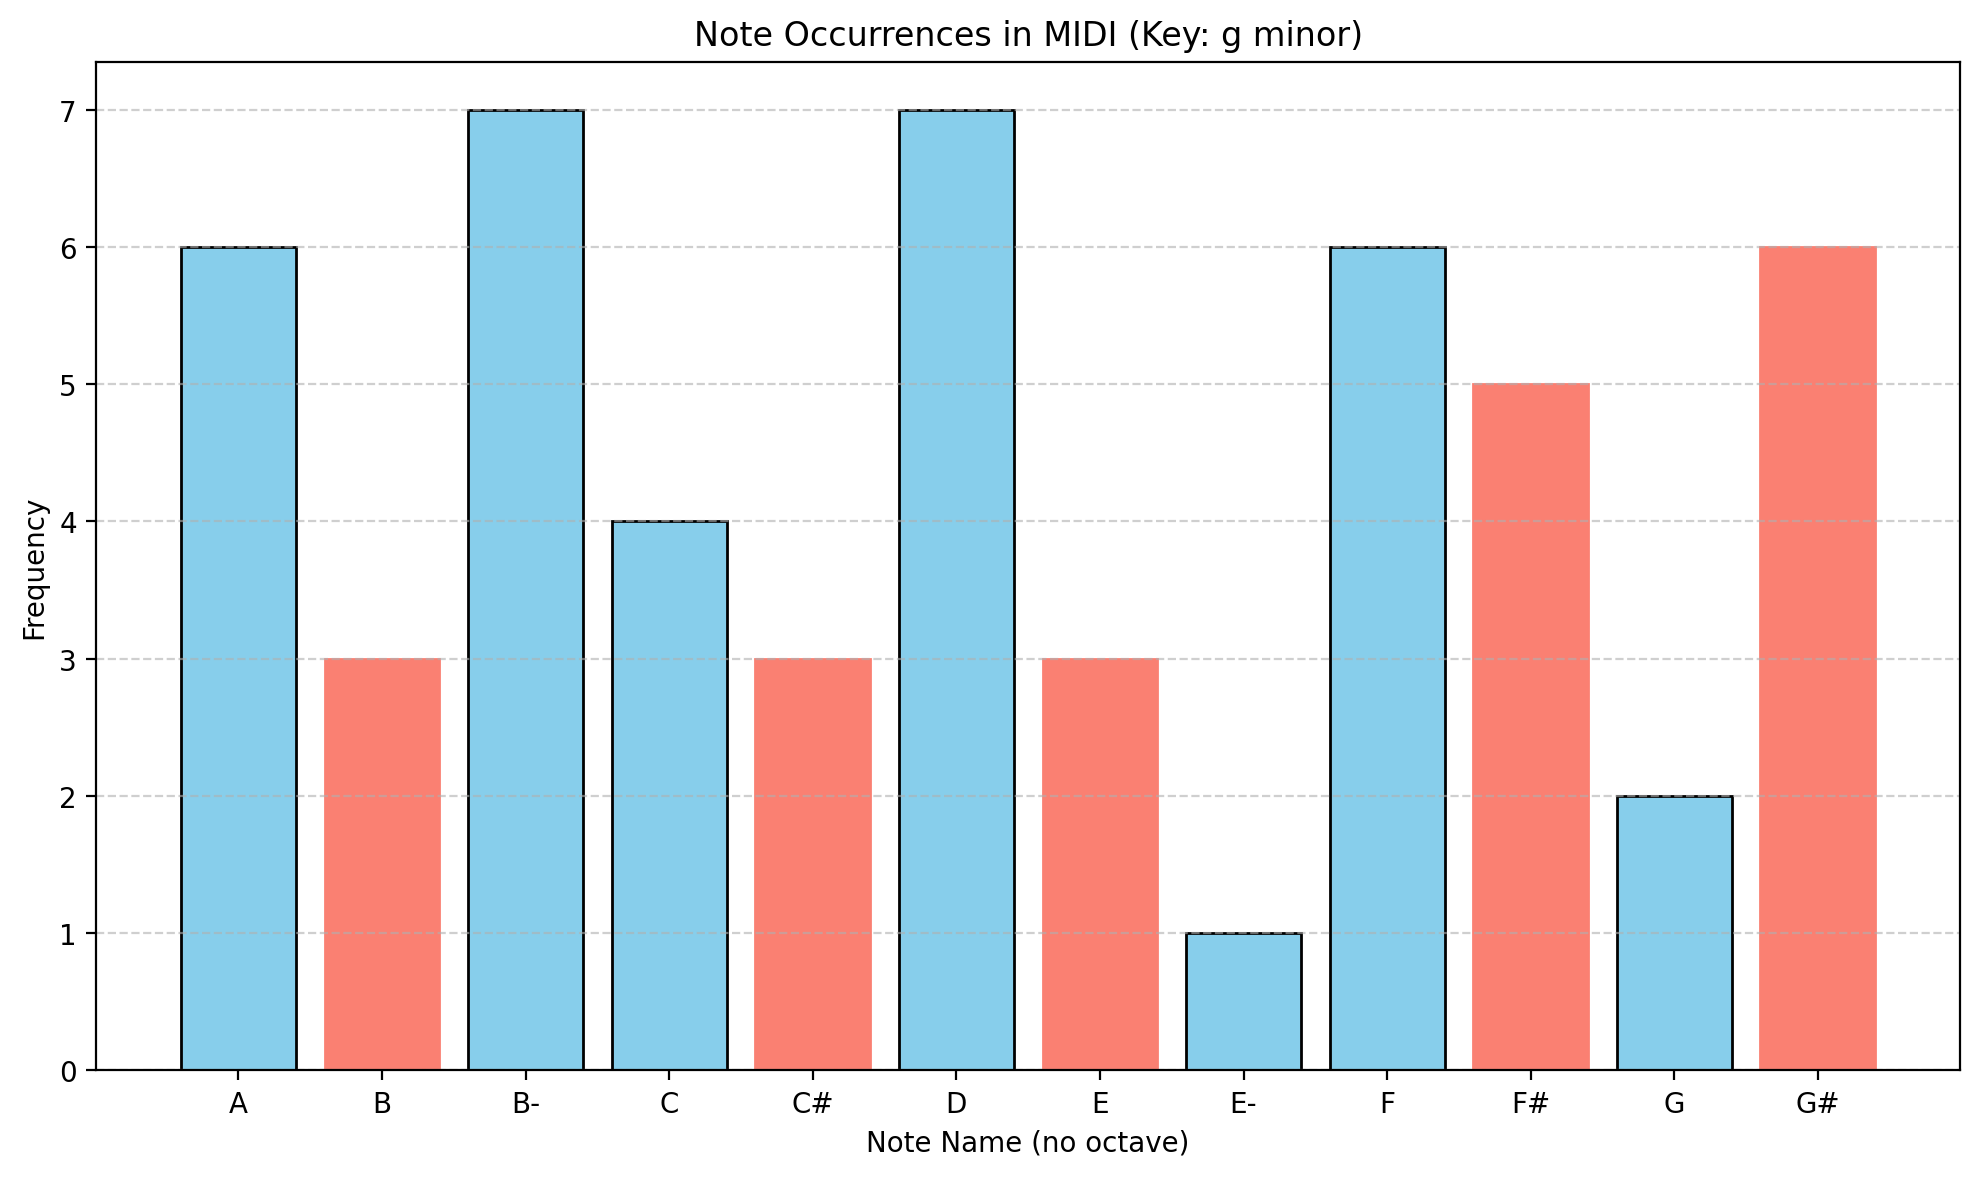


🕐 Time Signature(s) detected:
 - 4/4 at offset 0.0

📊 Note occurrences per beat position (aggregated):
 Beat 1.0:
   - B-: 2
   - G#: 1
   - A: 1
   - C: 2
   - F#: 1
   - E: 1
 Beat 1.25:
   - A: 1
   - G#: 1
   - F: 1
 Beat 1.5:
   - D: 1
   - G#: 1
 Beat 167/100:
   - E-: 1
   - D: 1
 Beat 1.75:
   - D: 1
 Beat 2.0:
   - B: 2
   - D: 1
   - G#: 1
 Beat 2.25:
   - F: 1
 Beat 233/100:
   - E: 1
   - A: 2
   - G#: 1
 Beat 2.5:
   - F#: 1
 Beat 267/100:
   - B: 1
   - B-: 1
 Beat 2.75:
   - A: 1
   - G: 1
 Beat 3.0:
   - F: 1
 Beat 3.25:
   - F#: 1
   - F: 1
 Beat 333/100:
   - C#: 2
   - D: 1
   - F#: 1
 Beat 3.5:
   - D: 1
 Beat 367/100:
   - B-: 1
 Beat 3.75:
   - F: 1
   - G#: 1
   - C: 1
 Beat 4.0:
   - C#: 1
   - A: 1
 Beat 4.25:
   - G: 1
   - B-: 2
   - D: 1
 Beat 467/100:
   - F: 1
   - F#: 1
   - B-: 1
   - E: 1
 Beat 4.75:
   - C: 1


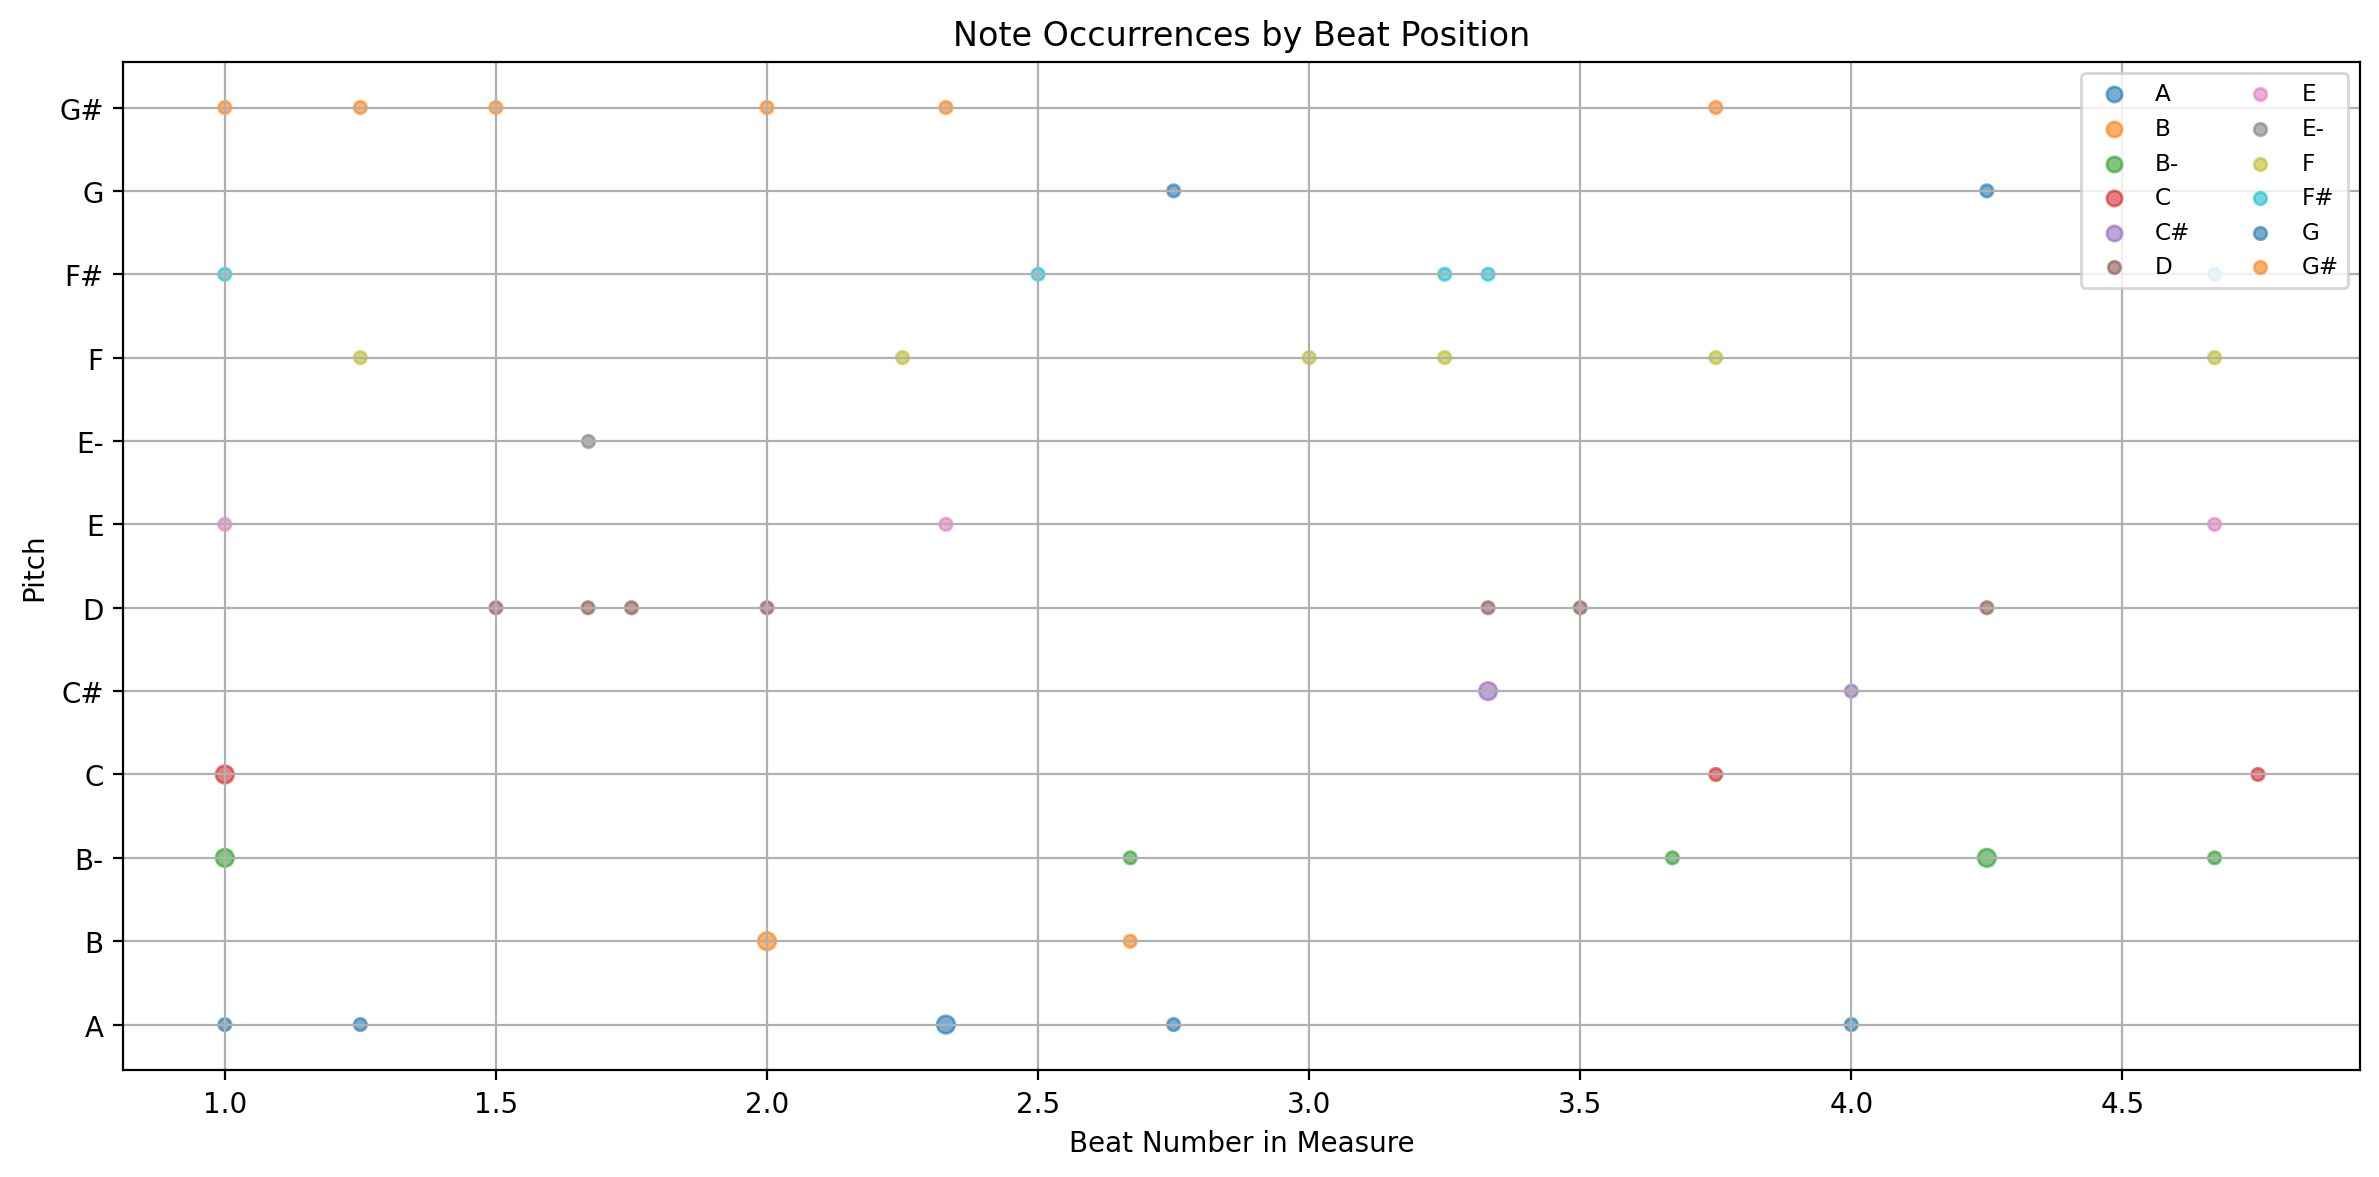

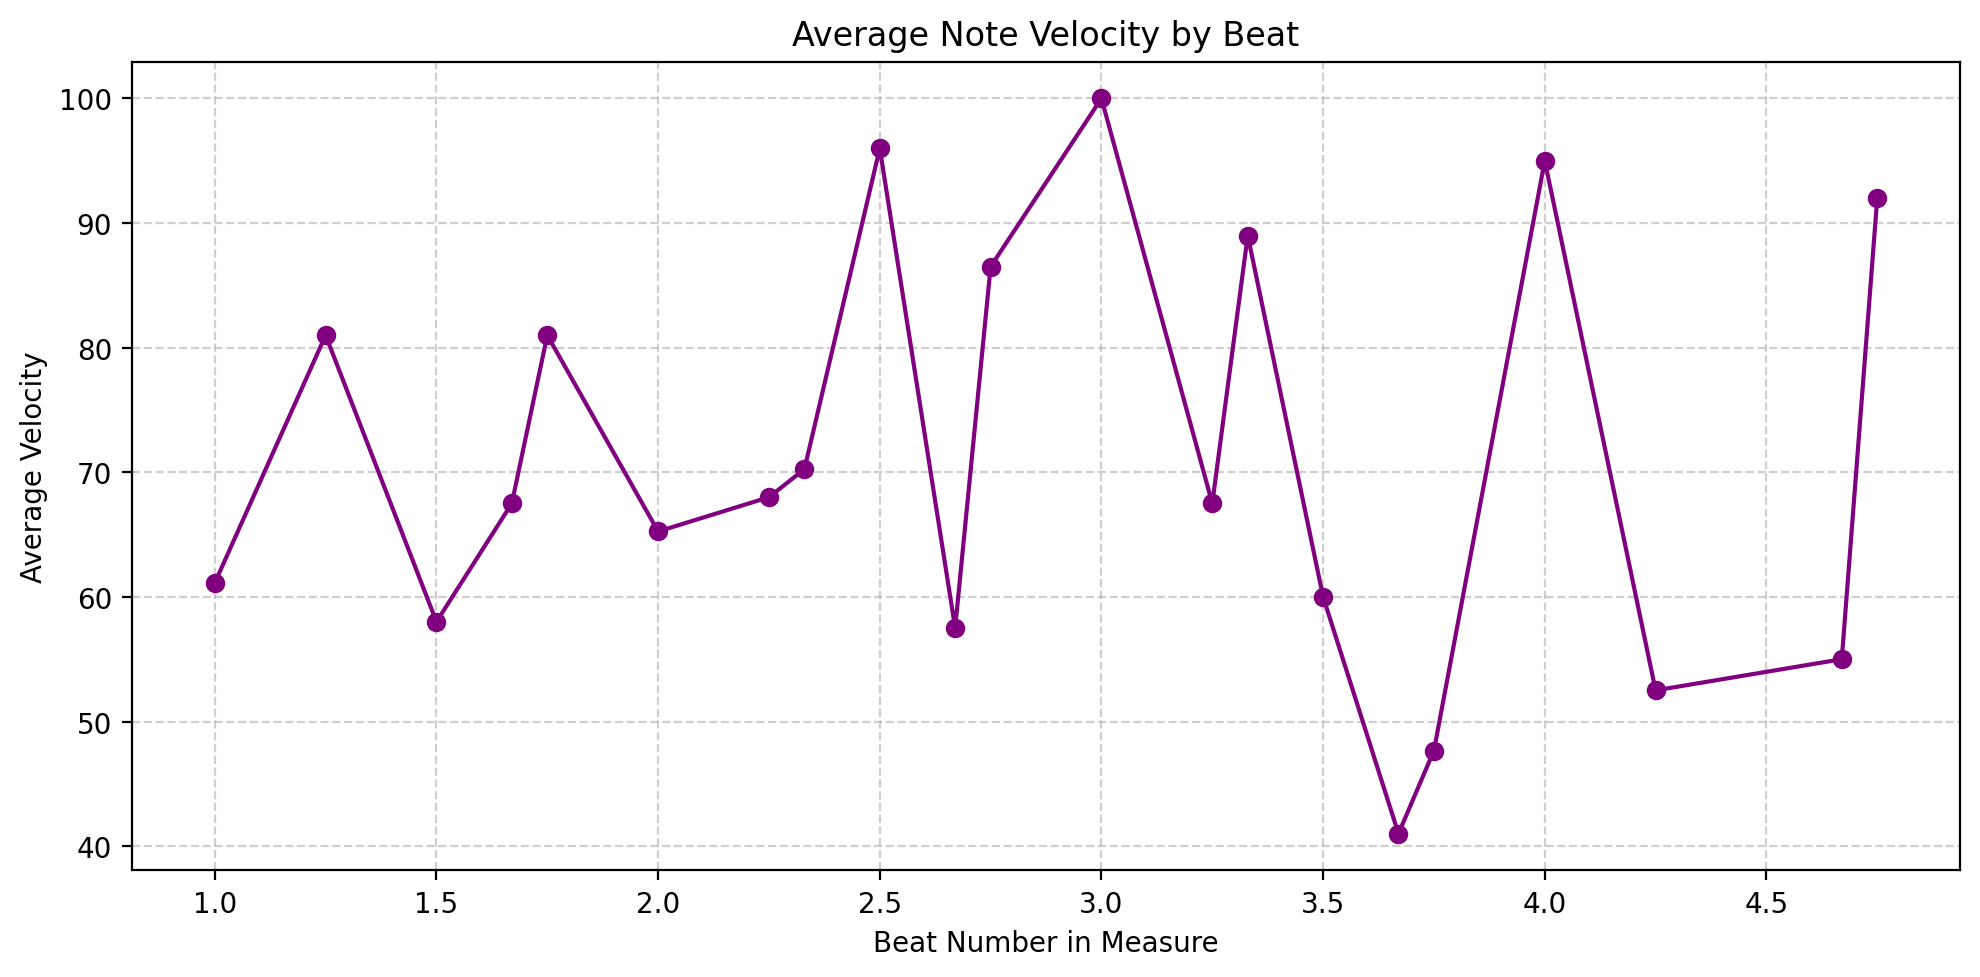

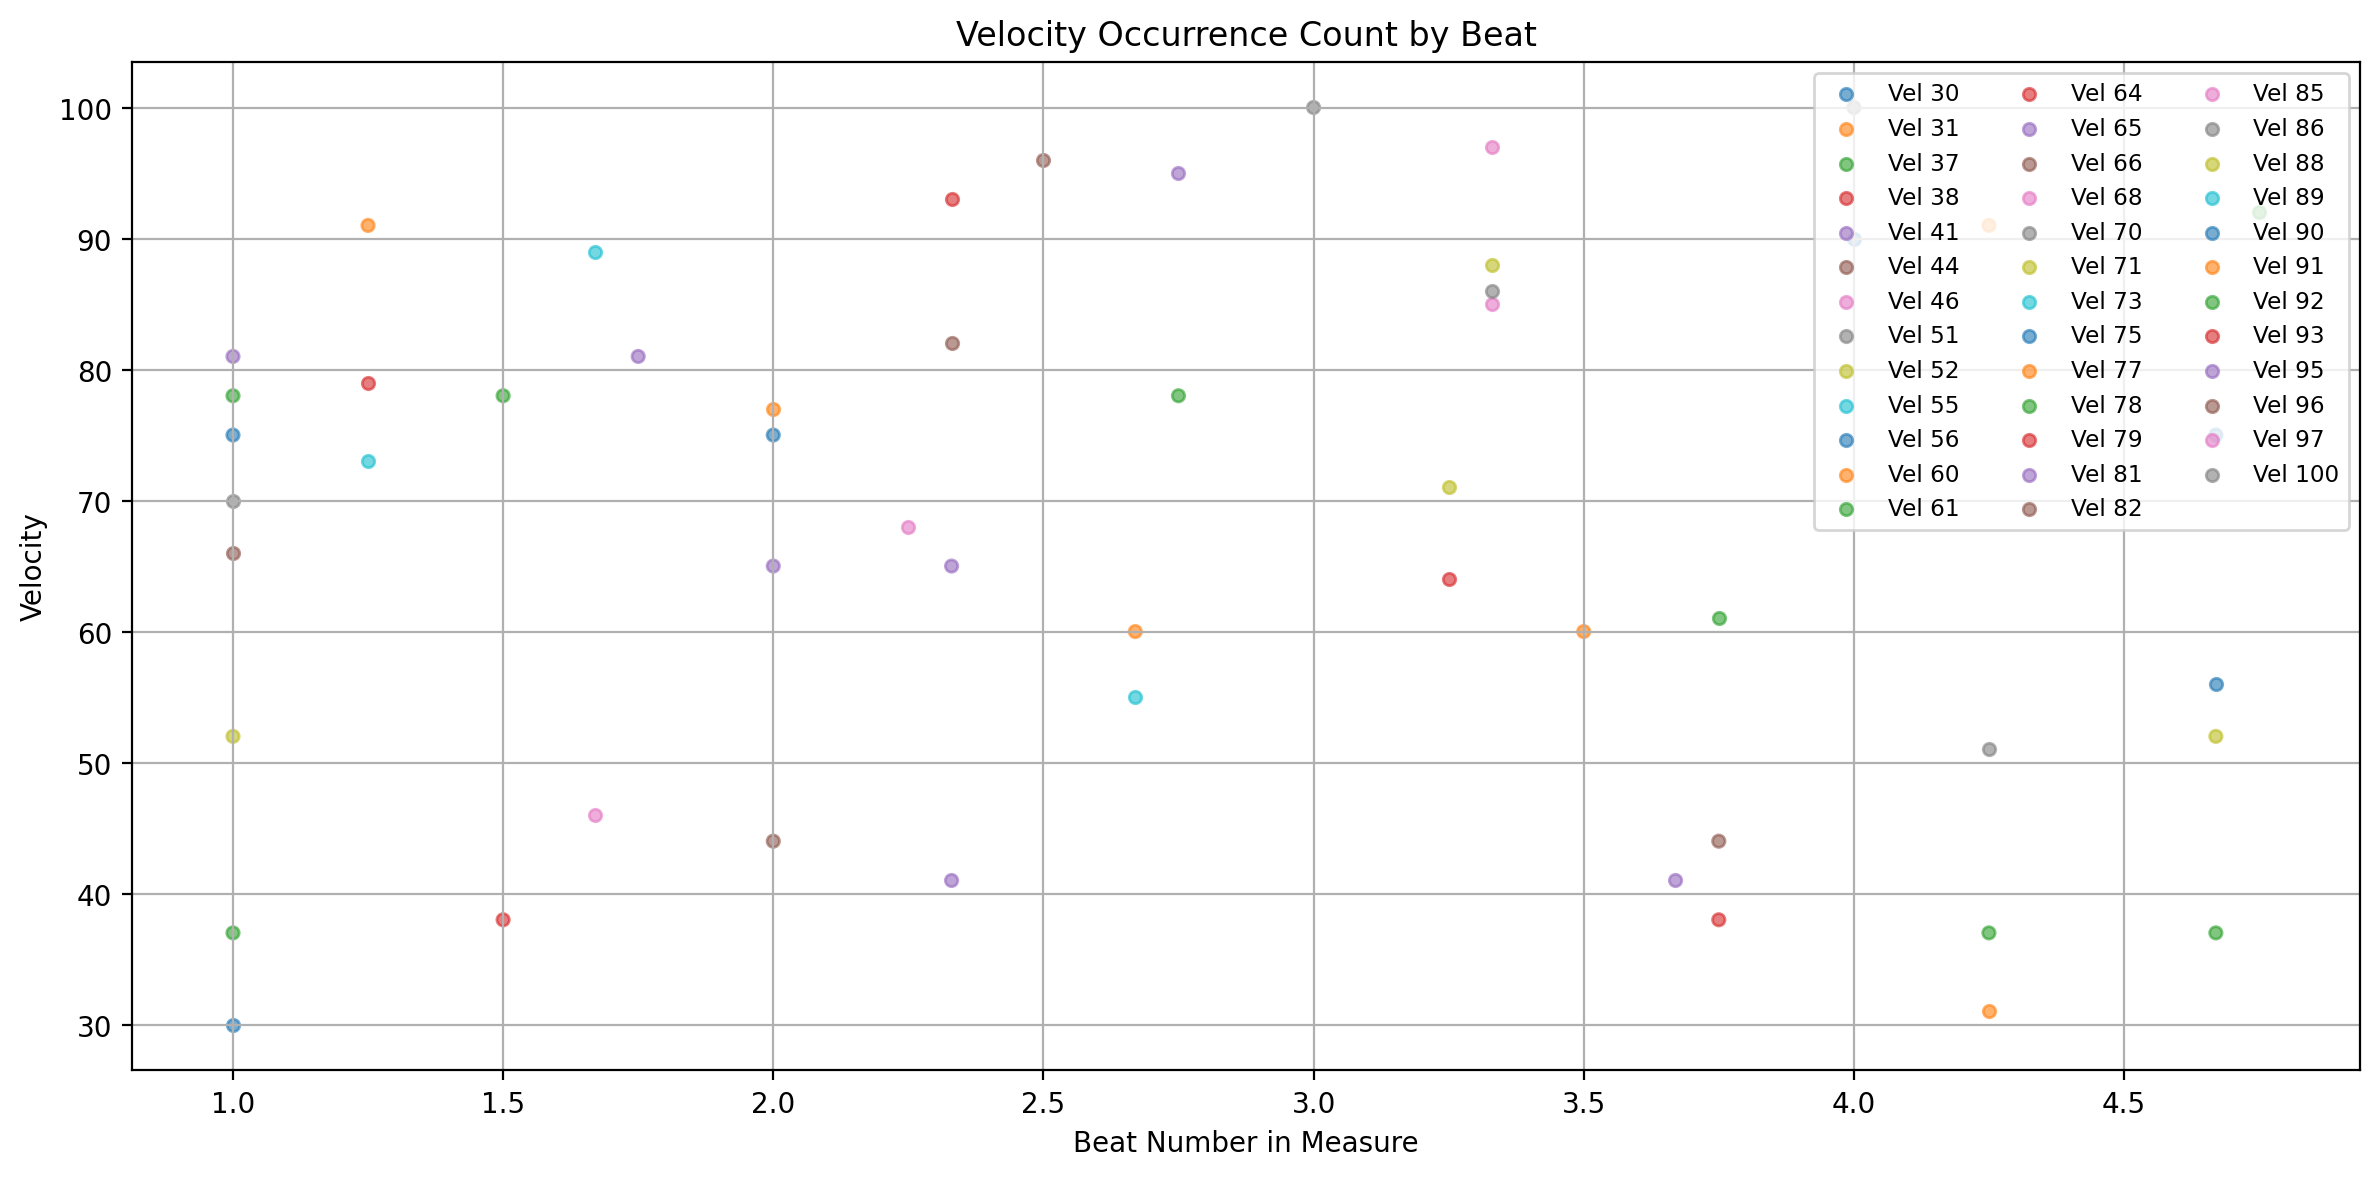

In [94]:
#midi_file_path = "generated-music/rnn/rnn_2.mid"
#midi_file_path = "generated-music/transformer/transformer_9.mid"
midi_file_path = "generated-music/random/random_1.mid"
analyze_midi_key_compliance(midi_file_path)